Try implementing MMD GAN on simple datasets: 2d points

In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


## Toy Dataset

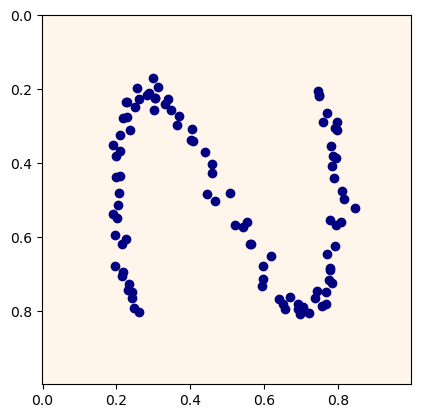

In [121]:
d = 2   # dimension of the data points

# # First dataset with 6 points
# n = 6
# y = torch.zeros((n,d), device=device)
# y[0, 0] = 0.9
# y[0, 1] = 0.2
# y[1, 0] = 0.75
# y[1, 1] = 0.8
# y[2, 0] = 0.3
# y[2, 1] = 0.4
# y[3, 0] = 0.4
# y[3, 1] = 0.7
# y[4, 0] = 0.45
# y[4, 1] = 0.75
# y[5, 0] = 0.7
# y[5, 1] = 0.5

# # make the points to be centered around [0,0]
# # get the mean
# mean = torch.mean(y, dim=0)
# y = y - mean

# Second dataset with 100 points, we use this for the rest of the
n = 100
t = torch.pi*torch.linspace(-.2,1.2,n)
y = .05*torch.randn((n,d))
y[:,0] += torch.cos(t)
y[:,1] += torch.sin(2*t)
y = .5 + .3*y
y = y.to(device)

# # make the points to be centered around [0,0]
# # get the mean
# mean_y = torch.mean(y, dim=0)
# y = y - mean_y

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device)/n

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
# plt.xticks([])
# plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Generator

In [112]:
class Generator(nn.Module):
    def __init__(self, n_z, n_hidden, n_out, device=torch.device('cpu')):
        super(Generator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_z, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, z):
        h1 = F.elu(self.fc1(z))
        h2 = F.elu(self.fc2(h1))
        h3 = F.elu(self.fc3(h2))
        return torch.tanh(self.fc4(h3))

torch.Size([100, 2])


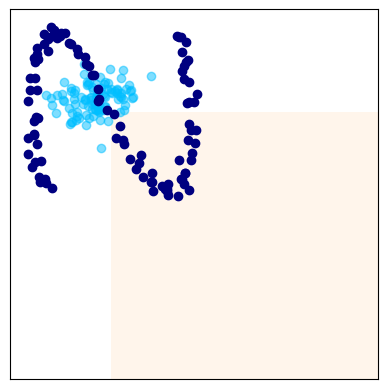

In [113]:
# plot initial config of the generator
# n_z = 10
# n_hidden = 100
# n_out = d
n_z=10 # should increase the dimension of the latent space; utile de sur paramétrer, 2 to 10
n_hidden=100 # big for 2d data; it is the most sensible
n_out=2

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# generate a batch of noise
b = 100
z = torch.randn(b, n_z, device=device)
# use generator to generate x
x = gen(z)

print(x.shape)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Autoencoder for intermediate results

We train an autoencoder for the dataset, so that we can use the latent space of this AE to calculate the MMD loss.

In [47]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, device=torch.device('cpu')):
        super(Autoencoder, self).__init__()
        self.device = device
        self.encoder = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n_out, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_in)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z, self.decoder(z)

In [48]:
# verify the input and output dimension of the autoencoder
n_x = d
n_hidden = 20
n_z_ae = 7

ae = Autoencoder(n_x, n_hidden, n_z_ae, device=device).to(device)

# generate a batch of data points
b_ae = 100
x = torch.randn(b_ae, n_x, device=device)
# use autoencoder to get the reconstructed data points
z_recon, x_recon = ae(x)

print(z_recon.shape, x_recon.shape)

torch.Size([100, 7]) torch.Size([100, 2])


In [52]:
# we create a simple dataset for the AE training
n_ae = 1000

t = torch.pi*torch.linspace(-.2,1.2,n_ae)
x_ae = .05*torch.randn((n_ae,d))
x_ae[:,0] += torch.cos(t)
x_ae[:,1] += torch.sin(2*t)
x_ae = .5 + .3*x_ae



# Optimizer
optimizer_ae = optim.Adam(ae.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
losses_ae = []

for epoch in range(num_epochs):
    optimizer_ae.zero_grad()
    z_recon, x_recon = ae(x_ae)
    loss_ae = F.mse_loss(x_recon, x_ae)
    loss_ae.backward()
    optimizer_ae.step()
    
    losses_ae.append(loss_ae.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss AE: {loss_ae.item():.4f}')

Epoch [10/100], Loss AE: 0.0251
Epoch [20/100], Loss AE: 0.0190
Epoch [30/100], Loss AE: 0.0136
Epoch [40/100], Loss AE: 0.0098
Epoch [50/100], Loss AE: 0.0063
Epoch [60/100], Loss AE: 0.0025
Epoch [70/100], Loss AE: 0.0003
Epoch [80/100], Loss AE: 0.0002
Epoch [90/100], Loss AE: 0.0001
Epoch [100/100], Loss AE: 0.0000


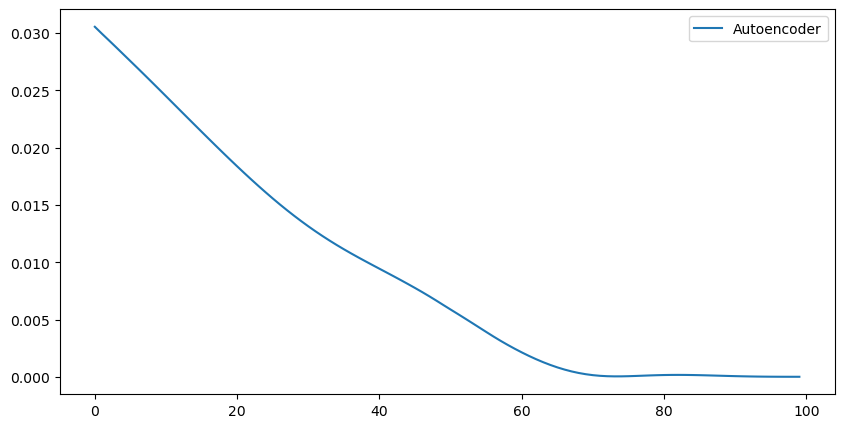

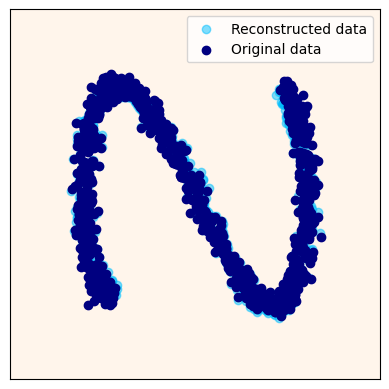

In [53]:
# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_ae, label='Autoencoder')
plt.legend()

# Plot
z_ae_recon, x_ae_recon = ae(x_ae)

# detach the tensor
x_ae_recon = x_ae_recon.detach()

fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(x_ae_recon[:, 0].cpu(), x_ae_recon[:,1].cpu(),c='deepskyblue',alpha=.5, label='Reconstructed data')
plt.scatter(x_ae[:, 0].cpu(), x_ae[:,1].cpu(),c='navy', label='Original data')
plt.legend()
plt.show()

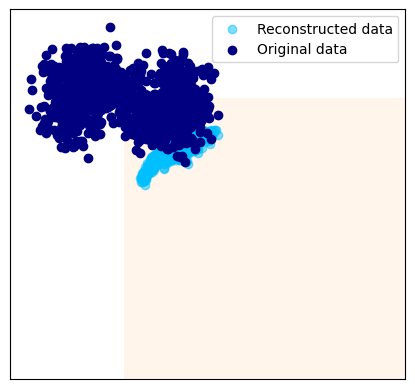

In [56]:
# we generate random data, and see the output of the AE
n_ae = 1000

# the input is a zigzag line with some noise
t = torch.pi*torch.linspace(-.2,1.2,n_ae)
x_ae = .05*torch.randn((n_ae,d))
x_ae[:,0] += 0.2 * torch.cos(t)
x_ae[:,1] += 0.1 * torch.sin(2*t)

# use the AE to get the reconstructed data
z_ae_recon, x_ae_recon = ae(x_ae)


# detach the tensor
x_ae_recon = x_ae_recon.detach()

fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(x_ae_recon[:, 0].cpu(), x_ae_recon[:,1].cpu(),c='deepskyblue',alpha=.5, label='Reconstructed data')
plt.scatter(x_ae[:, 0].cpu(), x_ae[:,1].cpu(),c='navy', label='Original data')
plt.legend()
plt.show()

## Discriminator

In [122]:
class Discriminator(nn.Module):
    def __init__(self, n_in, n_hidden, n_out, device=torch.device("cpu")):
        super(Discriminator, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        h1 = F.leaky_relu(self.fc1(x), 0.2)
        h2 = F.leaky_relu(self.fc2(h1), 0.2)
        h3 = F.leaky_relu(self.fc3(h2), 0.2)
        return torch.sigmoid(self.fc4(h3))

torch.Size([100, 1])


## MMD Loss

we use linear kernel, Gaussian kernel and rational_quadratic kernel.

In [7]:
# Function to calculate the linear kernel matrix
def linear_kernel(x, y):
    return x @ y.t()

In [8]:
# Function to calculate the RBF kernel matrix
def rbf_kernel(x, y, sigma):
    pairwise_distances = torch.cdist(x, y) ** 2
    return torch.exp(-pairwise_distances / (2 * sigma ** 2))

In [9]:
# Function to calculate the rational quadratic kernel matrix
def rational_quadratic_kernel(x, y, alpha=1.0):
    pairwise_distances = torch.cdist(x, y) ** 2
    return (1 + pairwise_distances / (2 * alpha)) ** -alpha

In [12]:
# Function to calculate the unbiased MMD with linear kernel
def compute_mmd_linear(x, y):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = linear_kernel(x, x)
    K_yy = linear_kernel(y, y)
    K_xy = linear_kernel(x, y)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

In [13]:
# Function to calculate the unbiased MMD
def compute_mmd_rbf(x, y, sigma=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rbf_kernel(x, x, sigma)
    K_yy = rbf_kernel(y, y, sigma)
    K_xy = rbf_kernel(x, y, sigma)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

In [14]:
# Function to calculate the unbiased MMD with rational quadratic kernel
def compute_mmd_rational_quadratic(x, y, alpha=1.0):
    m = x.size(0)
    n = y.size(0)

    # Calculate the kernel matrices
    K_xx = rational_quadratic_kernel(x, x, alpha)
    K_yy = rational_quadratic_kernel(y, y, alpha)
    K_xy = rational_quadratic_kernel(x, y, alpha)

    # Zero diagonal elements (without in-place operation)
    K_xx = K_xx - torch.diag_embed(torch.diagonal(K_xx))
    K_yy = K_yy - torch.diag_embed(torch.diagonal(K_yy))

    # Compute the MMD using the unbiased estimator
    term1 = K_xx.sum() / (m * (m - 1))
    term2 = K_yy.sum() / (n * (n - 1))
    term3 = 2 * K_xy.sum() / (m * n)

    mmd = term1 + term2 - term3
    return F.relu(mmd)

## Only training the Generator

linear kernel

Epoch [10/200], Loss G: 0.0023
Epoch [20/200], Loss G: 0.0156
Epoch [30/200], Loss G: 0.0135
Epoch [40/200], Loss G: 0.0000
Epoch [50/200], Loss G: 0.0000
Epoch [60/200], Loss G: 0.0028
Epoch [70/200], Loss G: 0.0008
Epoch [80/200], Loss G: 0.0000
Epoch [90/200], Loss G: 0.0000
Epoch [100/200], Loss G: 0.0000
Epoch [110/200], Loss G: 0.0000
Epoch [120/200], Loss G: 0.0000
Epoch [130/200], Loss G: 0.0000
Epoch [140/200], Loss G: 0.0000
Epoch [150/200], Loss G: 0.0000
Epoch [160/200], Loss G: 0.0000
Epoch [170/200], Loss G: 0.0000
Epoch [180/200], Loss G: 0.0000
Epoch [190/200], Loss G: 0.0000
Epoch [200/200], Loss G: 0.0003


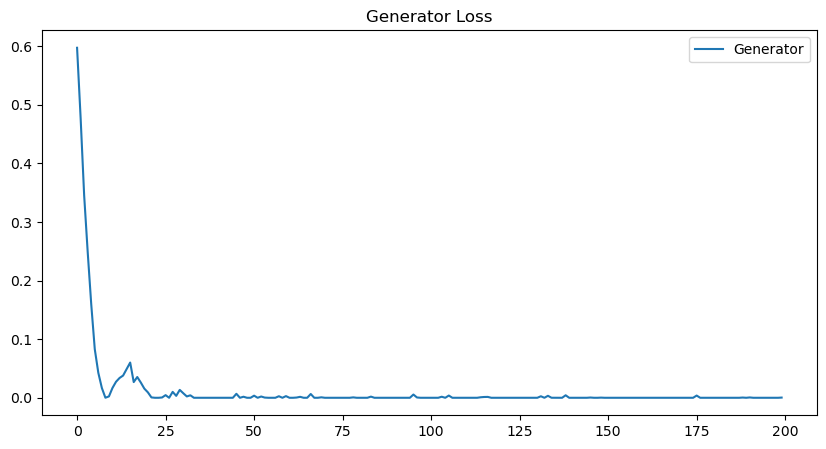

<Figure size 640x480 with 0 Axes>

In [147]:
n_z = 10
n_hidden = 100
n_out = d

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-3) # different lr with different local minima;

# Training loop
num_epochs = 200
batch_size = 100
losses_g = []

dots = []

for epoch in range(num_epochs):
    real_data = y.to(device)
    # print("real_data", real_data.shape)
    z = torch.randn(b, n_z, device=device)
    fake_data = gen(z)
    # print("fake_data", fake_data.shape)
    
    optimizer_g.zero_grad()
    mmd = compute_mmd_linear(real_data, fake_data)
    loss_g = mmd
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
        
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)
    

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
for i in range(len(dots)):
    # use detach
    
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    plt.savefig(f'./images_linear/epoch_{i}.png')
    plt.clf()
    
    

# plt.figure(figsize=(10, 5))
# plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c='blue', label='Real data')
# with torch.no_grad():
#     z = torch.randn(n, 2).to(device)
#     fake_data = gen(z).cpu()
#     plt.scatter(fake_data[:, 0], fake_data[:, 1], c='red', label='Generated data')
# plt.legend()
# plt.title('Generated Data vs Real Data')
# plt.show()


In [57]:
from PIL import Image
import os

In [125]:
# make the series of image into gif
# Set the path to the directory containing the PNG files
directory = './images_linear/'

# Load all the PNG files in the directory
images = []
for i in range(1, num_epochs):
    file_path = os.path.join(directory, f'epoch_{i}.png')
    images.append(Image.open(file_path))

# Save the images as a GIF
output_path = './gif_linear.gif'
images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

rbf kernel

Epoch [10/200], Loss G: 0.3383
Epoch [20/200], Loss G: 0.2720
Epoch [30/200], Loss G: 0.1779
Epoch [40/200], Loss G: 0.1260
Epoch [50/200], Loss G: 0.0799
Epoch [60/200], Loss G: 0.0356
Epoch [70/200], Loss G: 0.0155
Epoch [80/200], Loss G: 0.0045
Epoch [90/200], Loss G: 0.0020
Epoch [100/200], Loss G: 0.0016
Epoch [110/200], Loss G: 0.0010
Epoch [120/200], Loss G: 0.0009
Epoch [130/200], Loss G: 0.0013
Epoch [140/200], Loss G: 0.0007
Epoch [150/200], Loss G: 0.0006
Epoch [160/200], Loss G: 0.0007
Epoch [170/200], Loss G: 0.0004
Epoch [180/200], Loss G: 0.0005
Epoch [190/200], Loss G: 0.0001
Epoch [200/200], Loss G: 0.0000


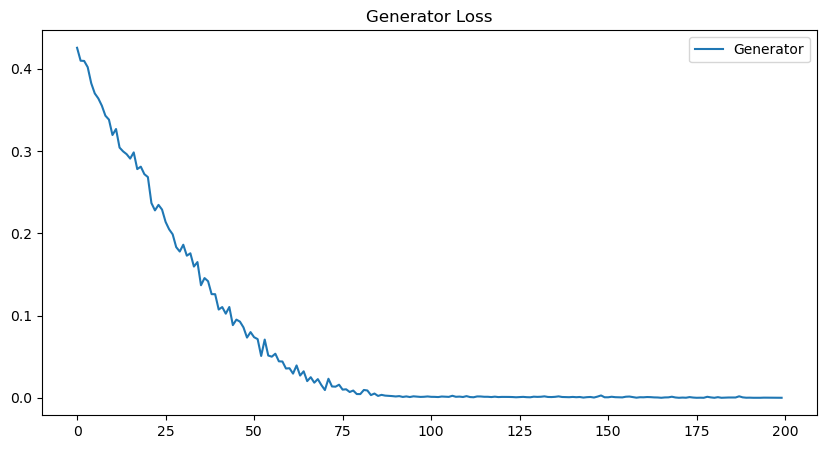

<Figure size 640x480 with 0 Axes>

In [148]:
gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 200
losses_g = []
dots = []

# take all the points instead of a batch
for epoch in range(num_epochs):
    real_data = y.to(device)
    z = torch.randn(100, n_z, device=device)
    fake_data = gen(z)
    
    optimizer_g.zero_grad()
    # mmd = compute_mmd_rbf(real_data, fake_data, sigma=0.8)+compute_mmd_rbf(real_data, fake_data, sigma=1)+compute_mmd_rbf(real_data, fake_data, sigma=2)
    mmd = compute_mmd_rbf(real_data, fake_data, sigma=1) # converges to the middle as the best
    loss_g = mmd
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
        
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)
        

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background

for i in range(len(dots)):
    # use detach
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    # print("drawn")
    plt.savefig(f'./images_rbf/epoch_{i}.png')
    plt.clf()
    

In [142]:
# make the series of image into gif
# Set the path to the directory containing the PNG files
directory = './images_rbf/'

# Load all the PNG files in the directory
images = []
for i in range(1, num_epochs):
    file_path = os.path.join(directory, f'epoch_{i}.png')
    images.append(Image.open(file_path))
    
# Save the images as a GIF
output_path = './gif_rbf.gif'
images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

Linear + rbf kernel

Epoch [10/200], Loss G: 0.4094
Epoch [20/200], Loss G: 0.3366
Epoch [30/200], Loss G: 0.2381
Epoch [40/200], Loss G: 0.1629
Epoch [50/200], Loss G: 0.1081
Epoch [60/200], Loss G: 0.0434
Epoch [70/200], Loss G: 0.0251
Epoch [80/200], Loss G: 0.0081
Epoch [90/200], Loss G: 0.0004
Epoch [100/200], Loss G: 0.0000
Epoch [110/200], Loss G: 0.0000
Epoch [120/200], Loss G: 0.0000
Epoch [130/200], Loss G: 0.0000
Epoch [140/200], Loss G: 0.0000
Epoch [150/200], Loss G: 0.0000
Epoch [160/200], Loss G: 0.0000
Epoch [170/200], Loss G: 0.0000
Epoch [180/200], Loss G: 0.0000
Epoch [190/200], Loss G: 0.0000
Epoch [200/200], Loss G: 0.0000


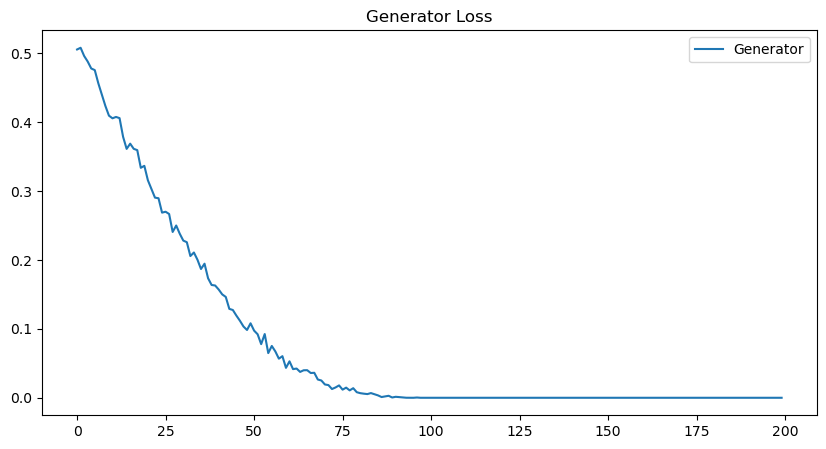

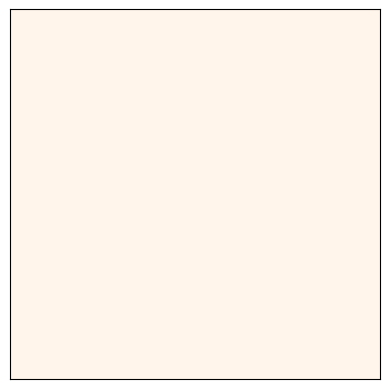

In [137]:
gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 200
losses_g = []
dots = []

# take all the points instead of a batch
for epoch in range(num_epochs):
    real_data = y.to(device)
    z = torch.randn(100, n_z, device=device)
    fake_data = gen(z)
    
    optimizer_g.zero_grad()
    mmd_linear = compute_mmd_linear(real_data, fake_data)
    mmd_rbf = compute_mmd_rbf(real_data, fake_data, sigma=1)
    loss_g = mmd_linear+mmd_rbf
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
        
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)
        

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background

for i in range(len(dots)):
    # use detach
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    # print("drawn")
    plt.savefig(f'./images_rbf_linear/epoch_{i}.png')
    plt.clf()
    

In [132]:
# make the series of image into gif
# Set the path to the directory containing the PNG files
directory = './images_rbf_linear/'

# Load all the PNG files in the directory
images = []
for i in range(1, num_epochs):
    file_path = os.path.join(directory, f'epoch_{i}.png')
    images.append(Image.open(file_path))
    
# Save the images as a GIF
output_path = './gif_rbf_linear.gif'
images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

RQ kernel

Epoch [10/200], Loss G: 0.2769
Epoch [20/200], Loss G: 0.2191
Epoch [30/200], Loss G: 0.1668
Epoch [40/200], Loss G: 0.0969
Epoch [50/200], Loss G: 0.0624
Epoch [60/200], Loss G: 0.0326
Epoch [70/200], Loss G: 0.0165
Epoch [80/200], Loss G: 0.0056
Epoch [90/200], Loss G: 0.0006
Epoch [100/200], Loss G: 0.0006
Epoch [110/200], Loss G: 0.0001
Epoch [120/200], Loss G: 0.0009
Epoch [130/200], Loss G: 0.0005
Epoch [140/200], Loss G: 0.0000
Epoch [150/200], Loss G: 0.0000
Epoch [160/200], Loss G: 0.0007
Epoch [170/200], Loss G: 0.0000
Epoch [180/200], Loss G: 0.0000
Epoch [190/200], Loss G: 0.0000
Epoch [200/200], Loss G: 0.0000


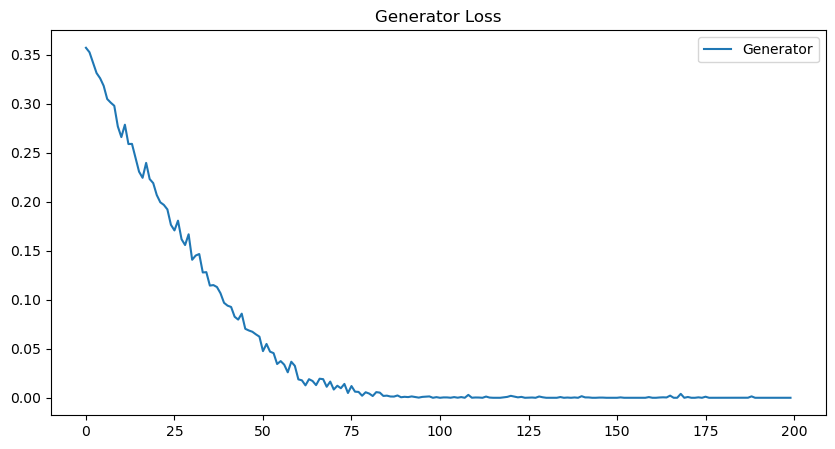

<Figure size 640x480 with 0 Axes>

In [134]:
n_z = 10
n_hidden = 100
n_out = d

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 200
losses_g = []
dots = []

for epoch in range(num_epochs):
    real_data = y.to(device)
    z = torch.randn(b, n_z, device=device)
    fake_data = gen(z)
    
    optimizer_g.zero_grad()
    mmd = compute_mmd_rational_quadratic(real_data, fake_data, alpha=1.2)
    loss_g = mmd
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
    
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)

        

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background

for i in range(len(dots)):
    # use detach
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    plt.savefig(f'./images_rq/epoch_{i}.png')
    plt.clf()

In [135]:
# make the series of image into gif
# Set the path to the directory containing the PNG files
directory = './images_rq/'

# Load all the PNG files in the directory
images = []
for i in range(1, num_epochs):
    file_path = os.path.join(directory, f'epoch_{i}.png')
    images.append(Image.open(file_path))
    
# Save the images as a GIF
output_path = './gif_rq.gif'
images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

rbf+ linear kernel

Epoch [10/200], Loss G: 1.9488
Epoch [20/200], Loss G: 1.4366
Epoch [30/200], Loss G: 1.0789
Epoch [40/200], Loss G: 0.6626
Epoch [50/200], Loss G: 0.3983
Epoch [60/200], Loss G: 0.1491
Epoch [70/200], Loss G: 0.0847
Epoch [80/200], Loss G: 0.0496
Epoch [90/200], Loss G: 0.0118
Epoch [100/200], Loss G: 0.0255
Epoch [110/200], Loss G: 0.0055
Epoch [120/200], Loss G: 0.0069
Epoch [130/200], Loss G: 0.0097
Epoch [140/200], Loss G: 0.0055
Epoch [150/200], Loss G: 0.0081
Epoch [160/200], Loss G: 0.0152
Epoch [170/200], Loss G: 0.0024
Epoch [180/200], Loss G: 0.0014
Epoch [190/200], Loss G: 0.0001
Epoch [200/200], Loss G: 0.0016


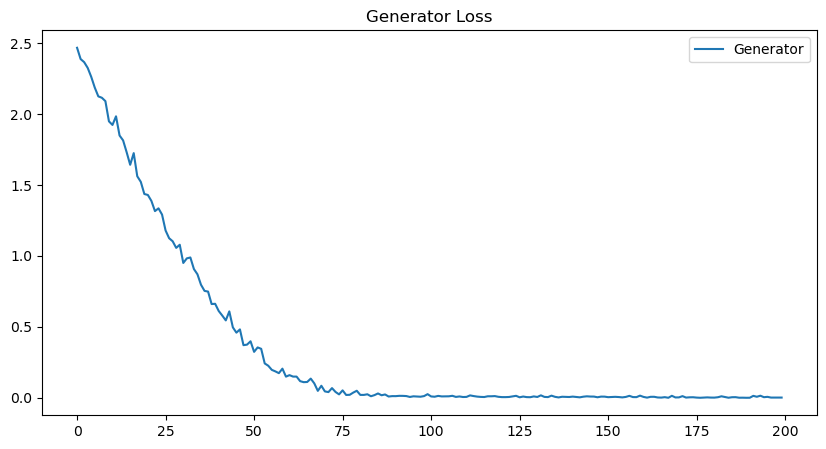

<Figure size 640x480 with 0 Axes>

In [145]:
n_z = 10
n_hidden = 100
n_out = d

gen = Generator(n_z, n_hidden, n_out, device=device).to(device)

# Optimizer
optimizer_g = optim.Adam(gen.parameters(), lr=1e-4)

# Training loop
num_epochs = 200
losses_g = []
dots = []

for epoch in range(num_epochs):
    real_data = y.to(device)
    z = torch.randn(b, n_z, device=device)
    fake_data = gen(z)
    
    optimizer_g.zero_grad()
    mmd = compute_mmd_rational_quadratic(real_data, fake_data, alpha=1) + compute_mmd_rational_quadratic(real_data, fake_data, alpha=1.2)+compute_mmd_rational_quadratic(real_data, fake_data, alpha=0.8)+compute_mmd_rbf(real_data, fake_data, sigma=0.8)+compute_mmd_rbf(real_data, fake_data, sigma=1)+compute_mmd_rbf(real_data, fake_data, sigma=2)+compute_mmd_linear(real_data, fake_data)
    loss_g = mmd
    loss_g.backward()
    optimizer_g.step()
    
    losses_g.append(loss_g.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_g.item():.4f}')
    
    # save the dots in each epochs so that we can finally plot the changes in each epoch
    dots.append(fake_data)

        

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator')
plt.legend()
plt.title('Generator Loss')

# plot the generated dots as gif
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background

for i in range(len(dots)):
    # use detach
    dots_detached = dots[i].detach()
    plt.scatter(dots_detached[:, 0].cpu(), dots_detached[:,1].cpu(),c='deepskyblue',alpha=.5)
    plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
    plt.savefig(f'./images_rq_rbf/epoch_{i}.png')
    plt.clf()

In [146]:
# make the series of image into gif
# Set the path to the directory containing the PNG files
directory = './images_rq_rbf/'

# Load all the PNG files in the directory
images = []
for i in range(1, num_epochs):
    file_path = os.path.join(directory, f'epoch_{i}.png')
    images.append(Image.open(file_path))
    
# Save the images as a GIF
output_path = './gif_rq_rbf.gif'
images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=200, loop=0)

Change the initialization for the generator weights; different scattering

change the settings for generator, e.g. hidden layer size

completely different features e.g. classification middle features



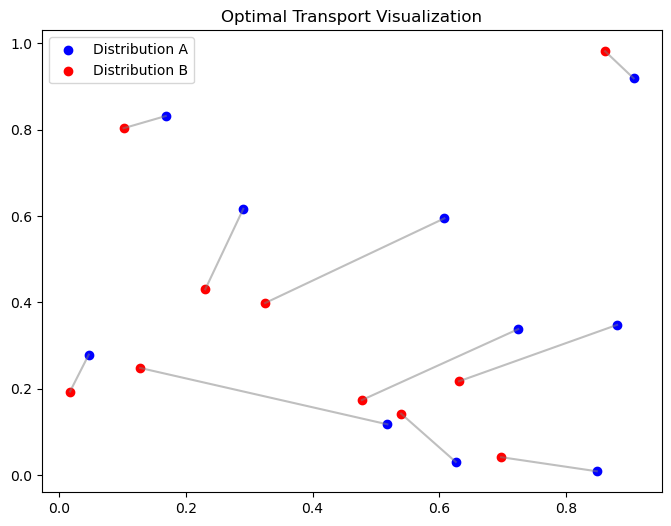

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import ot

# Creating two distributions as arrays of points
n_dots = 10
a = np.random.rand(n_dots, 2)  # First distribution
b = np.random.rand(n_dots, 2)  # Second distribution

# Uniform weights for each distribution
a_weights = np.ones((n_dots,)) / n_dots
b_weights = np.ones((n_dots,)) / n_dots

# Calculate the cost matrix (Euclidean distance)
cost_matrix = ot.dist(a, b, metric='sqeuclidean')

# Compute the optimal transport plan
transport_plan = ot.emd(a_weights, b_weights, cost_matrix)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(a[:, 0], a[:, 1], color='blue', label='Distribution A')
plt.scatter(b[:, 0], b[:, 1], color='red', label='Distribution B')
for i in range(n_dots):
    for j in range(n_dots):
        if transport_plan[i, j] > 1e-5:  # Only draw significant transports
            plt.plot([a[i, 0], b[j, 0]], [a[i, 1], b[j, 1]], 'grey', alpha=0.5)

plt.title('Optimal Transport Visualization')
plt.legend()
plt.show()

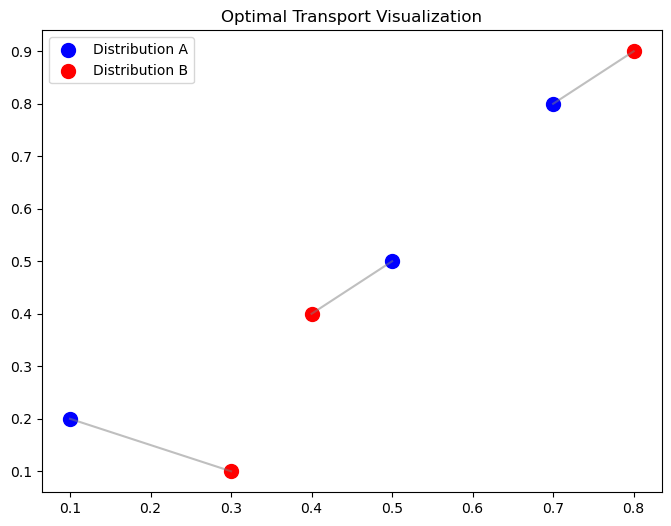

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import ot  # Import the Python Optimal Transport library

# Define the sets of points
points_set1 = np.array([[0.5, 0.5], [0.1, 0.2], [0.7, 0.8]])
points_set2 = np.array([[0.4, 0.4], [0.3, 0.1], [0.8, 0.9]])

# Assuming uniform distribution, so each point has equal weight
weights_set1 = np.ones((points_set1.shape[0],)) / points_set1.shape[0]
weights_set2 = np.ones((points_set2.shape[0],)) / points_set2.shape[0]

# Compute the cost matrix (Euclidean distance between each pair of points)
cost_matrix = ot.dist(points_set1, points_set2, metric='euclidean')

# Compute the optimal transport plan using the EMD algorithm
transport_plan = ot.emd(weights_set1, weights_set2, cost_matrix)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(points_set1[:, 0], points_set1[:, 1], color='blue', label='Distribution A', s=100)
plt.scatter(points_set2[:, 0], points_set2[:, 1], color='red', label='Distribution B', s=100)

# Draw lines illustrating the optimal transport plan
for i in range(len(points_set1)):
    for j in range(len(points_set2)):
        if transport_plan[i, j] > 1e-5:  # draw significant transports only
            plt.plot([points_set1[i, 0], points_set2[j, 0]],
                     [points_set1[i, 1], points_set2[j, 1]], 'grey', alpha=0.5)

plt.title('Optimal Transport Visualization')
plt.legend()
plt.show()


In [151]:
# Define the sets of points
# Each row corresponds to a point (e.g., [x, y] coordinates in 2D space)
points_set1 = np.array([[0.5, 0.5], [0.1, 0.2], [0.7, 0.8]])
points_set2 = np.array([[0.4, 0.4], [0.3, 0.1], [0.8, 0.9]])

# Assuming uniform distribution, so each point has equal weight
weights_set1 = np.ones((points_set1.shape[0],)) / points_set1.shape[0]
weights_set2 = np.ones((points_set2.shape[0],)) / points_set2.shape[0]

# Compute the cost matrix (Euclidean distance between each pair of points)
cost_matrix = ot.dist(points_set1, points_set2, metric='euclidean')

# Calculate the Wasserstein distance using the EMD solver
wasserstein_distance = ot.emd2(weights_set1, weights_set2, cost_matrix)

print("Wasserstein Distance:", wasserstein_distance)

Wasserstein Distance: 0.16881650340819965


Wasserstein Distance: 0.13635404958389696


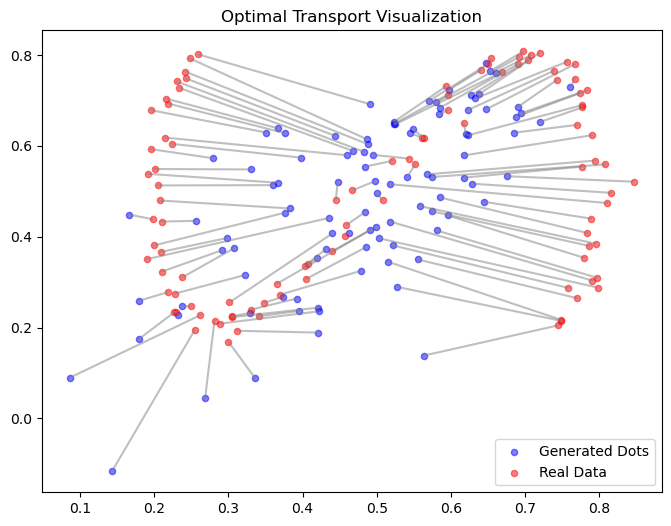

In [160]:
# calculate the Wasserstein distance between two distributions
# dots[0] and y

# convert the tensors to numpy arrays
dots_np = dots[199].detach().cpu().numpy()
y_np = y.cpu().numpy()

# Assuming uniform distribution, so each point has equal weight
weights_dots = np.ones((dots_np.shape[0],)) / dots_np.shape[0]
weights_y = np.ones((y_np.shape[0],)) / y_np.shape[0]

# Compute the cost matrix (Euclidean distance between each pair of points)
cost_matrix = ot.dist(dots_np, y_np, metric='euclidean')

# Calculate the Wasserstein distance using the EMD solver
wasserstein_distance = ot.emd2(weights_dots, weights_y, cost_matrix)

print("Wasserstein Distance:", wasserstein_distance)


# show the best transport plan
# Compute the optimal transport plan using the EMD algorithm
transport_plan = ot.emd(weights_dots, weights_y, cost_matrix)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(dots_np[:, 0], dots_np[:, 1], color='blue', label='Generated Dots', s=20, alpha=0.5)
plt.scatter(y_np[:, 0], y_np[:, 1], color='red', label='Real Data', s=20, alpha=0.5)

# Draw lines illustrating the optimal transport plan
for i in range(len(dots_np)):
    for j in range(len(y_np)):
        if transport_plan[i, j] > 1e-6:  # draw significant transports only
            plt.plot([dots_np[i, 0], y_np[j, 0]],
                     [dots_np[i, 1], y_np[j, 1]], 'grey', alpha=0.5)
            
plt.title('Optimal Transport Visualization')
plt.legend()
plt.show()


In [163]:
# Compute the cost matrix (Euclidean distance between each pair of points)
cost_matrix = ot.dist(y_np, y_np, metric='euclidean')

# Calculate the Wasserstein distance using the EMD solver
wasserstein_distance = ot.emd2(weights_dots, weights_y, cost_matrix)

print("Wasserstein Distance:", wasserstein_distance)

Wasserstein Distance: 0.0
